# TempEst-NEWT Case Studies

This Notebook covers preliminary data exploration through case studies to inform development of the watershed-scale component of the TempEst-NEXT model.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
import NEWT
pd.options.mode.chained_assignment = None

In [2]:
base_path = r"X:\Rio.Data\StreamTemperature\NEXT\ReadyData\daymet_aoi"
gsamp = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\GageSample.csv",
                   dtype={"id": "str"})

In [3]:
def mergeit(out="AllData.csv", resume=-1):
    dat = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\AllGageData.csv",
                      dtype={"id": "str"})
    ids = dat["id"].unique()
    dat["date"] = pd.to_datetime(dat["date"])
    bad_count = 0
    for (index, cid) in enumerate(gsamp["id"]):
        # Fix leading zeroes.
        data = dat[dat["id"] == cid] if cid in ids else dat[dat["id"] == "0" + cid]
        if index > resume:
            try:
                weather_path = base_path + "\\USGS-" + cid + ".csv"
                weather = pd.read_csv(weather_path)
                weather["date"] = pd.to_datetime(weather["datetime"]).dt.normalize()
                wmean = weather.pivot(index="date", columns="variable", values="mean")
                result = data[["id", "date", "temperature.mean"]].merge(wmean, on="date")
                result.to_csv(out,
                                mode="w" if index == 0 else "a",
                                header=(index == 0),
                                index=False)
            except FileNotFoundError:
                bad_count = bad_count + 1
            except Exception as e:
                print(e)
    print(bad_count)

In [4]:
# mergeit()

In [5]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data["date"] = pd.to_datetime(data["date"])
print(len(data["id"].unique()))
data

954


,id,date,temperature,prcp,srad,swe,tmax,tmin,vp
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704
...,...,...,...,...,...,...,...,...,...
3060720,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785
3060721,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664
3060722,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638
3060723,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240


In [6]:
def get_candidate(cid):
    return data[data["id"] == cid]
    # data = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\AllGageData.csv",
    #                   dtype={"id": "str"})
    # data["date"] = pd.to_datetime(data["date"])
    # weather_path = base_path + "\\USGS-" + cid + ".csv"
    # weather = pd.read_csv(weather_path)
    # stdat = data[data["id"] == cid]
    # weather["date"] = pd.to_datetime(weather["datetime"]).dt.normalize()
    # wmean = weather.pivot(index="date", columns="variable", values="mean")
    # return stdat[["date", "temperature.mean"]].merge(wmean, on="date")

In [7]:
# This is Eagle River Below Milk Creek Near Wolcott, CO
# Appears to be unregulated, freezes in winter, max temperature ~20 C, discharge ~50-2000 cfs,
# elevation ~2100 m
candidate_eagle = "394220106431500"

cid = candidate_eagle
csd = get_candidate(cid)

# Modeled Anomaly

Using a modified (dynamic) SCHEMA, the first step is to design the modeled daily anomaly approach.  This presumably won't directly copy from an LST-based approach, and hopefully we can achieve better accuracy than an NSE of ~0.45.

A few thoughts at the single-watershed (calibrated) scale:

- Can we decompose anomaly response into unit thermohydrographs?  There are probably established approaches to functional decomposition of this form.  Wavelets?
- Does sensitivity vary dynamically with season?
- Some ideas for dynamic sensitivity drivers:
  - Snowpack
  - Sustained subzero air temperature (frozen river won't randomly thaw)
  - Precipitation has little overall effect, but it may increase the response sensitivity to an anomaly
- If we end up sticking with a rolling mean, the model code should just keep a list of relevant observations and drop the old ones instead of reprocessing the whole dataset every day.

## Prepare Anomaly Data

In [327]:
def anomilize(data):
    data["day"] = data["date"].dt.day_of_year
    try:
        data = data.merge(rts.ThreeSine.from_data(data.rename(columns={"temperature.mean": "temperature"})).generate_ts(), on="day")  # adds `actemp`
        data["st_anom"] = data["temperature.mean"] - data["actemp"]
        # data["stm_anom"] = data["temperature.max"] - data["actemp"]
        data = data.merge(data.groupby("day")["tmax"].mean().rename("tmax_day"), on="day")
        data["at_anom"] = data["tmax"] - data["tmax_day"]
        data = data.merge(data.groupby("day")["vp"].mean().rename("vp_day"), on="day")
        data["vp_anom"] = data["vp"] - data["vp_day"]
        return data
    except ValueError:
        return data.assign(at_anom=np.NaN, st_anom=np.NaN, actemp=np.NaN)

In [52]:
ac = anomilize(csd)
ac

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_21832\215106962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day"] = data["date"].dt.day_of_year


,id,date,temperature.mean,prcp,srad,swe,tmax,tmin,vp,day,actemp,st_anom,tmax_day,at_anom
0,394220106431500,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,274,9.243199,-0.243199,13.567267,1.280782
1,394220106431500,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,275,8.977150,1.154100,12.926053,-3.247565
2,394220106431500,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,276,8.710292,0.993875,14.263163,0.180993
3,394220106431500,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,277,8.442873,1.252960,13.341467,3.368101
4,394220106431500,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,278,8.175141,2.725900,11.766584,3.879240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,394220106431500,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,361,-0.020726,0.020726,-2.526517,6.681047
5535,394220106431500,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,362,-0.032142,0.032142,-4.035087,4.154790
5536,394220106431500,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,363,-0.041320,0.041320,-4.550913,-3.221829
5537,394220106431500,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,364,-0.048276,0.048276,-2.946670,-1.560114


<Axes: xlabel='date'>

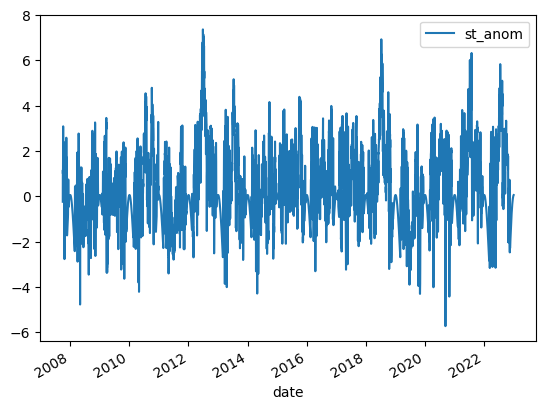

In [53]:
ac.plot(x="date", y="st_anom")  # definite autocorrelations.

<Axes: xlabel='date'>

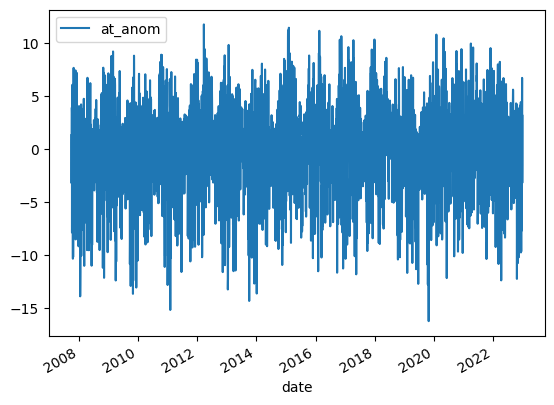

In [54]:
ac.plot(x="date", y="at_anom")

There is an anomaly autocorrelation, which begins quite high (~0.9).  There appear to be two ranges of decay: it drops to ~0.1 by day 40 in an exponentialish fashion, then remains nearly constant until day 100 before dropping to 0 by day 120.

(0.0, 120.0)

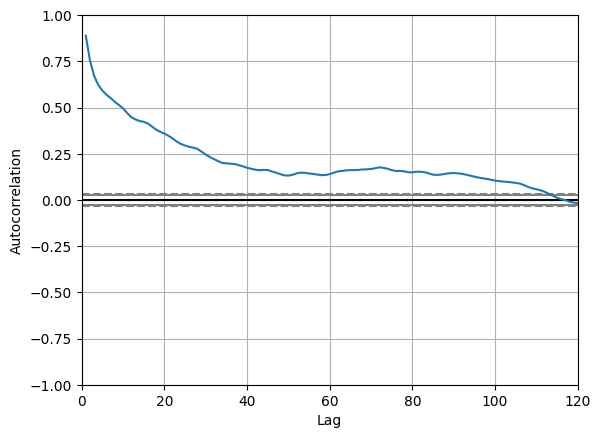

In [42]:
pdp.autocorrelation_plot(ac["st_anom"])
plt.xlim(0, 120)

## Deconvolution to Unit Thermohydrographs

Can it be done and does it make sense?

This is a sort of deconvolution problem.  For ST $s$ and AT $a$, where the daily coefficient of the unit thermohydrograph $K$ is $k_x=K(x)$:

$$
    s(t) = \sum_{i=0}^{t} a_{i}\cdot k_{t-i}
$$

I.e.,

$$
    s(t) = A\cdot (k_t, k_{t-1}, ..., k_0) = A\cdot (0..0, K)
$$

Where the coefficient array $K$ is concatenated with a series of zeroes for padding.

So for a matrix of zero-padded $K$ rows, $\mathbb{K}$, we have $S = \mathbb{K}A$.

This is easy to solve for $A$, but this time we want an optimal, approximate solution for $\mathbb{K}$, knowing $S$ and $A$.

It appears that unit hydrograph decomposition is an active research problem.  Fenton (2024) summarizes prior work at: https://www.sciencedirect.com/science/article/pii/S0022169424004293

In lieu of that, let's just solve a linear relationship between $s$ and a lagged subset of $a$.

Doesn't work that well for Eagle River, where the correlation of that fit is poor (R2~0.25).

0   -0.702850
1   -0.614695
2   -0.761736
3   -1.537886
4   -1.277129
5   -0.208265
6   -0.697764
7   -1.860349
8   -1.338035
9   -0.277074
dtype: float64


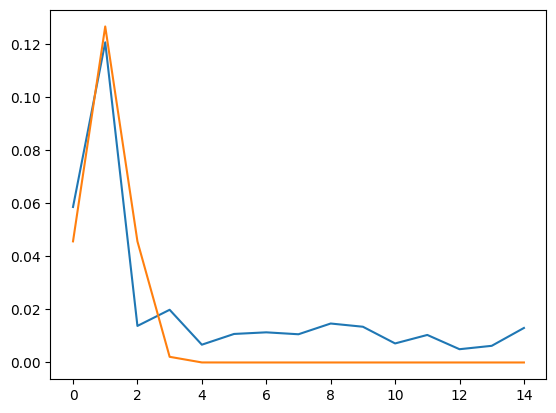

In [218]:
N = 14
y = np.array([ac["st_anom"]]).transpose()[N:,]
x0 = ac["at_anom"]
xs = np.array([x0] + [x0.shift(n) for n in range(1,N+1)]).transpose()[N:,]
sol = np.linalg.lstsq(xs, y, rcond=None)[0]
# print(np.sqrt(soln[1] / len(x0)))
prd = pd.Series((xs @ sol)[:,0])
ax = pd.Series(sol[:,0]).plot()
# pd.Series(scipy.stats.lognorm.pdf(np.arange(0, N+1), 10)*24+0.1).plot(ax=ax)
# conv = scipy.stats.poisson.pmf(np.arange(0, N+1), 1)/3
conv = scipy.stats.norm.pdf(np.arange(0, N+1), 1, 0.7) / 4.5
# conv = np.concatenate(([0.06], np.exp(-np.arange(1, N+1)) * 0.35))
pd.Series(conv).plot(ax=ax)
print(prd[:10])

5525
5525


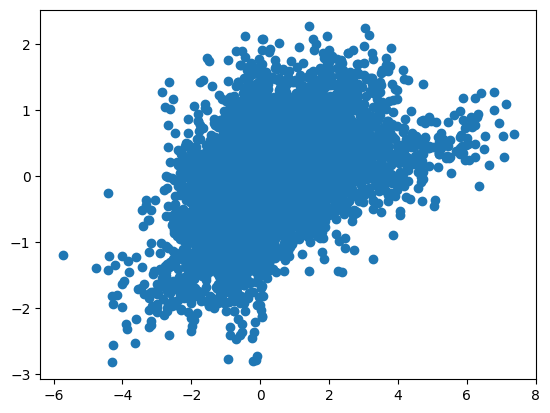

In [289]:
# conv = np.concatenate(([0.9], np.exp(-np.arange(1, 15)/2.1) * 1.5 + 0.15))
# Faster than a regular convolution
# TODO: I think it's backwards
yp = scipy.signal.fftconvolve(x0, conv, mode="same")[7:-7]
print(len(y))
print(len(yp))
plt.scatter(y, yp)

## Large-Set Comparison

Eagle River does not work that well because there's simply a low correlation between AT and ST anomaly (probably necessary to account for snowpack/precip).  What do distributions look like across sites?

In [340]:
def to_coefs(ac, N=14):
    y = np.array([ac["st_anom"]]).transpose()[N:,]
    x0 = ac["at_anom"]
    hu0 = ac["vp_anom"]
    xs = np.array([x0] + [x0.shift(n) for n in range(1,N+1)] + [hu0] + [hu0.shift(n) for n in range(1,N+1)]).transpose()[N:,]
    try:
        sol = np.linalg.lstsq(xs, y, rcond=None)[0]
        return pd.DataFrame({"I": np.arange(0, N+1), "kt": sol[:(N+1),0], "kv": sol[(N+1):,0]})
    except:
        return pd.DataFrame({"I": np.arange(0, N+1), "kt": np.NaN, "kv": np.NaN})

In [330]:
anomed = data.groupby("id").apply(anomilize, include_groups=False)

In [341]:
coefs = anomed.groupby("id").apply(to_coefs).dropna()

Surprisingly, it seems to be quite consistent that the response is dominated by lag-1 air temperature, and the form does look rather log-normal.  The medians are fit quite well by a log-normal distribution with a standard deviation of 1, divided by 2.5.

Humidity response seems to be dominated by day 0 and 1, but is quite variable.

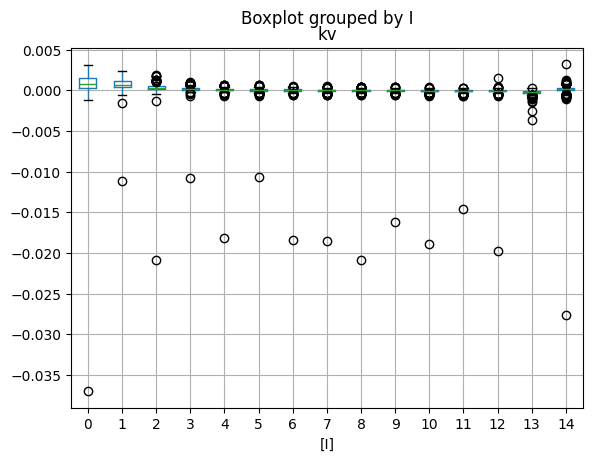

In [349]:
ax = coefs[["I", "kv"]].boxplot(by="I")
# prco = pd.Series(scipy.stats.norm.pdf(np.arange(-1, 15), 1, 0.7) / 3)
prco = pd.Series(scipy.stats.lognorm.pdf(np.arange(0, 15), 1)/2.5, index=range(1,16))
# prco.plot(ax=ax)

In [374]:
def convolver(data):
    # Assume data is anom'ed and grouped.  Relationship zeroes-out at day 7, so ignore after that.
    conv = scipy.stats.lognorm.pdf(np.arange(0, 7), 1)
    # inward = len(conv) // 2
    data["anom_atmod"] = scipy.signal.fftconvolve(data["at_anom"], conv, mode="full")[:-(len(conv) - 1)]
    data["anom_hummod"] = scipy.signal.fftconvolve(data["vp_anom"], [1,1], mode="full")[:-1]
    try:
        sol = np.linalg.lstsq(np.array(data[["anom_atmod", "anom_hummod"]]), data["st_anom"].to_numpy().transpose(), rcond=None)[0]
        data["anom_mod"] = data["anom_atmod"] * sol[0] + data["anom_hummod"] * sol[1]
        data["at_coef"] = sol[0]
        data["vp_coef"] = sol[1]
        return data
    except:
        pass

In [375]:
mod = anomed.groupby("id").apply(convolver, include_groups=False)

This actually works reasonably well, almost as well as the TE2 model - and that, just with AT (no vapor pressure)!  So, that's probably about as good as it will get.  With vapor pressure, R2 is up to about 0.41.  Median mean bias is -0.38 C and median MAE is 1.3 C.  Median NSE is 0.33, mean slightly lower - presumably low NSE is due to the bias.  Where'd the bias come from and why do the vast majority of sites have a bias?

In [376]:
mod.groupby("id").apply(lambda x: x["st_anom"].corr(x["anom_mod"])**2).describe()

count    581.000000
mean       0.407624
std        0.217341
min        0.001699
25%        0.243965
50%        0.413688
75%        0.598519
max        0.805084
dtype: float64

In [377]:
mod.groupby("id").apply(lambda x: np.mean(x["anom_mod"] - x["st_anom"])).dropna().describe()

count    581.000000
mean      -0.378141
std        1.186149
min       -2.051897
25%       -0.784561
50%       -0.499984
75%       -0.086056
max       25.147277
dtype: float64

In [378]:
mod.groupby("id").apply(lambda x: 1 - np.mean((x["anom_mod"] - x["st_anom"])**2) / np.std(x["st_anom"])**2).dropna().describe()

count    581.000000
mean       0.305517
std        0.236744
min       -0.594666
25%        0.147831
50%        0.329300
75%        0.496279
max        0.727127
dtype: float64

<Axes: >

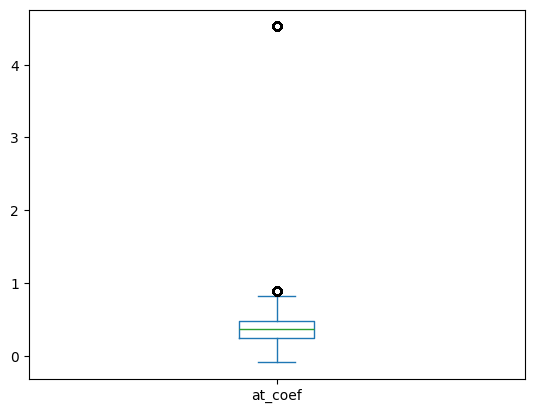

In [380]:
mod["at_coef"].plot.box()

<Axes: >

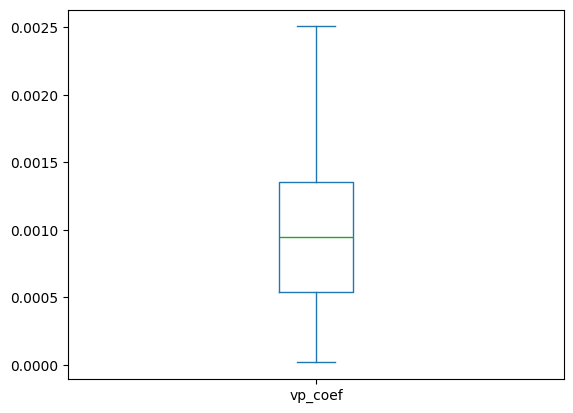

In [383]:
mod[mod["vp_coef"] > 0]["vp_coef"].plot.box()

## Dynamic Sensitivity

At sites, does the *daily* coefficient correlate with SWE or precipitation?  Ignore humidity, its impact is low.

There is no identifiable correlation.  SWE might be more relevant for assessing three-sine timing.

Time to build a model class!

In [400]:
def daily_coef(data):
    # Assume data is anom'ed and grouped.  Relationship zeroes-out at day 7, so ignore after that.
    conv = scipy.stats.lognorm.pdf(np.arange(0, 7), 1)
    # inward = len(conv) // 2
    data["anom_atmod"] = scipy.signal.fftconvolve(data["at_anom"], conv, mode="full")[:-(len(conv) - 1)]
    data["anom_hummod"] = scipy.signal.fftconvolve(data["vp_anom"], [1,1], mode="full")[:-1]
    nzr = data[abs(data["anom_atmod"]) > 0.1]
    nzr["at_coef"] = nzr["st_anom"] / nzr["anom_atmod"]
    return nzr

def get_cor(data):
    return pd.DataFrame({
        "SWE": [data["at_coef"].corr(data["swe"])],
        "p": data["at_coef"].corr(data["prcp"])
    })

In [396]:
coefs = anomed.groupby("id").apply(daily_coef)

In [401]:
coef_cor = coefs.groupby("id").apply(get_cor)

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [403]:
coef_cor.describe()

,SWE,p
count,548.000000,581.000000
mean,-0.009530,0.008485
std,0.042831,0.021890
min,-0.131907,-0.072992
25%,-0.036665,-0.005464
50%,-0.008080,0.008940
75%,0.015613,0.021701
max,0.166994,0.089249


In [404]:
(coef_cor**2).describe()

,SWE,p
count,5.480000e+02,5.810000e+02
mean,1.921959e-03,5.503335e-04
std,3.076771e-03,9.059363e-04
min,2.393890e-11,1.490637e-08
25%,1.445675e-04,5.649847e-05
50%,6.371509e-04,2.267194e-04
75%,2.494238e-03,6.755013e-04
max,2.788685e-02,7.965374e-03


# Watershed Model Test

In [8]:
def cal_val(data, lin_ssn=False, throw_er=False, rtn_model=True,
           start=330, until=30, xs=["at"]):
    try:
        cut = round(data.shape[0] * 0.7)
        train = data[:cut]
        test = data[cut:]
        model = NEWT.Watershed.from_data(train, lin_ssn, start=start, until=until, xs=xs)
        res = model.run_series(test)
        return (res, model) if rtn_model else res
    except Exception as e:
        if throw_er:
            raise e

In [9]:
(pr, model) = cal_val(csd, False, True)

In [10]:
model.seasonality.to_df()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
0,6.914757,7.155289,325.0,83.0,160.0,239.0,2.75226,1.891333,NaN,0.628866


In [11]:
model.statics["seasonality"].to_df()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
0,6.914757,7.155289,325.0,83.0,160.0,239.0,2.75226,1.891333,NaN,0.628866


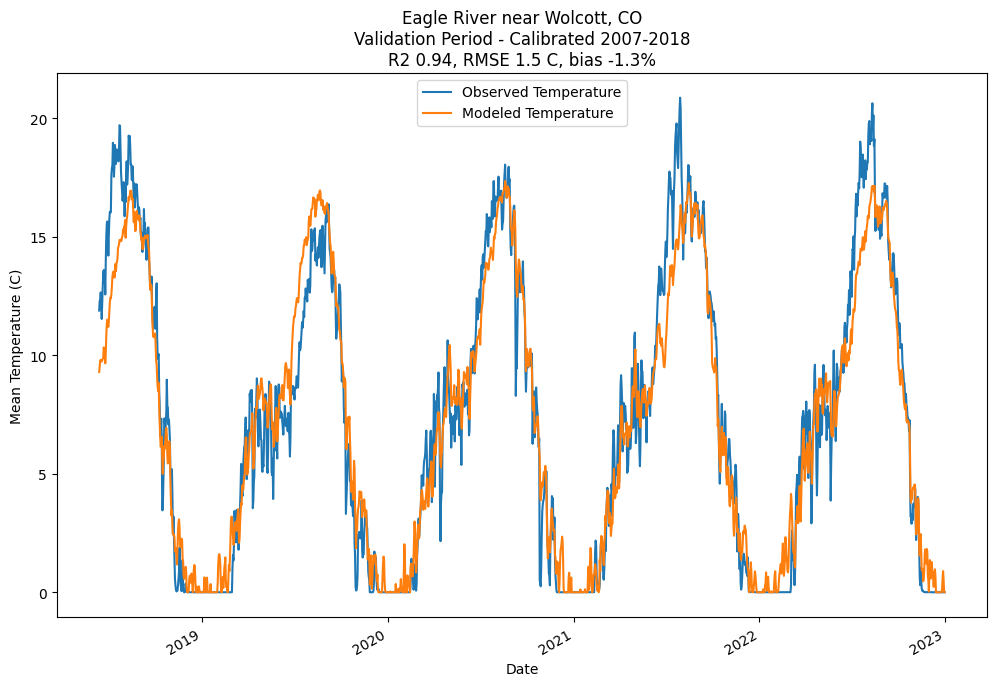

In [24]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
pr.plot(x="date", y="temperature", ax=ax, label="Observed Temperature")
pr.plot(x="date", y="temp.mod", ax=ax, label="Modeled Temperature")
ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
_ = ax.set_title("Eagle River near Wolcott, CO\nValidation Period - Calibrated 2007-2018\nR2 0.94, RMSE 1.5 C, bias -1.3%")
fig.savefig("EagleRivCalibrated.png")

In [13]:
def perf(pr):
    if pr is not None and "temperature" in pr:
        return pd.DataFrame({
            "R2": [pr["temperature"].corr(pr["temp.mod"])**2],
            "RMSE": np.sqrt(np.mean((pr["temp.mod"] - pr["temperature"])**2)),
            "NSE": 1 - np.mean((pr["temp.mod"] - pr["temperature"])**2) / np.std(pr["temperature"])**2,
            "Pbias": np.mean(pr["temp.mod"] - pr["temperature"]) / np.mean(pr["temperature"])*100,
            "Bias": np.mean(pr["temp.mod"] - pr["temperature"]),
            "MaxMiss": pr.assign(year=lambda x: x["date"].dt.year).groupby("year")[["temperature", "temp.mod"]].max().assign(maxmiss=lambda x: x["temperature"] - x["temp.mod"])["maxmiss"].max()
        })
    else:
        pass

In [14]:
perf(pr)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.940741,1.5477,0.936158,-1.332517,-0.097757,3.597928


In Eagle River *without* linear seasonality:

- R2 = 0.94, RMSE = 1.55 C, NSE = 0.94, bias = -1.3% = -0.1 C, median max miss = 2.76 C, maximum max miss = 3.6 C
- Shape is accurately captured in 2019-2020, but there are seasonal departures in 2018, 2022, and 2021 (biggest to smallest)

In Eagle River *with* linear seasonality (tmax day 330-30):

- R2 = 0.94, RMSE = 1.53 C, NSE = 0.94, bias = -1% = -0.07 C, median max miss = 2.6 C, maximum max miss = 3.2 C
- Shape is accurately captured every year, though it overestimates spring temperatures a bit in 2019 and misses the absolute peaks in warm years

Without the bug, the difference is subtle but identifiable.

In [15]:
preds = data.groupby("id").apply(lambda x: cal_val(x, lin_ssn=False, rtn_model=False), include_groups=False)

In [16]:
preds

date  temperature       prcp        srad  swe  \
id                                                                         
01010000        0    2014-10-22     6.789583   1.451763  196.096630  0.0   
                1    2014-10-23     7.188542  18.446787   84.404945  0.0   
                2    2014-10-24     7.115625   2.005072   86.606360  0.0   
                3    2014-10-25     7.248958   6.381760  186.072240  0.0   
                4    2014-10-26     7.626042   3.868103   61.989770  0.0   
...                         ...          ...        ...         ...  ...   
453004122510301 1663 2022-12-27     8.954167  14.705484  102.965160  NaN   
                1664 2022-12-28     8.227083   7.167581   75.575645  NaN   
                1665 2022-12-29     7.947917  12.223548   76.049675  NaN   
                1666 2022-12-30     8.160417   7.248064   86.775970  NaN   
                1667 2022-12-31     8.472917   1.040323  103.396450  NaN   

                           tmax      tmin         vp  day    actemp      anom  \
id                                                                              
01010000        0     10.281011  0.852441  650.17360  295  8.678136 -0.106454   
                1      6.834916  2.390627  725.62463  296  8.338206 -0.059663   
                2      6.292076  2.558955  734.42580  297  7.999765  0.282727   
                3     13.149472  1.213496  667.40265  298  7.663161  0.557855   
                4      7.058496  4.062082  816.76074  299  7.328738  0.657008   
...                         ...       ...        ...  ...       ...       ...   
453004122510301 1663  12.431773       NaN  926.78296  361  5.689308  2.162222   
                1664   8.427581       NaN  822.70820  362  5.675475  2.705651   
                1665   8.684195       NaN  839.17084  363  5.664910  1.404302   
                1666  10.729195       NaN  917.87340  364  5.657570  1.670763   
                1667   9.031774       NaN  856.59326  365  5.653407  2.589739   

                      temp.mod  
id                              
01010000        0     8.571681  
                1     8.278544  
                2     8.282492  
                3     8.221016  
                4     7.985746  
...                        ...  
453004122510301 1663  7.851531  
                1664  8.381126  
                1665  7.069212  
                1666  7.328333  
                1667  8.243146  

[890196 rows x 12 columns]

In [17]:
preds.groupby("id").apply(perf).median()

R2         0.956468
RMSE       1.444546
NSE        0.952316
Pbias     -0.178560
Bias      -0.022692
MaxMiss    1.053678
dtype: float64

In [26]:
preds.groupby("id").apply(perf).describe()

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,0.927819,1.695847,0.893343,-0.149607,0.161799,1.057645
std,0.108915,5.515424,0.422249,4.908217,5.205105,4.368107
min,0.004173,0.356439,-8.121073,-104.467504,-1.595306,-118.281250
25%,0.934321,1.218188,0.922795,-1.657050,-0.217344,0.185292
50%,0.956468,1.444546,0.952316,-0.178560,-0.022692,1.053678
75%,0.968581,1.676580,0.965984,1.352159,0.178285,2.068002
max,0.986930,166.409694,0.986738,32.469822,155.782604,14.935642


So far so good: across the sample, median R2 is 0.96 (!), RMSE is 1.44 C, NSE is 0.95.  Also, the median maximum underestimate of a maximum temperature is just 1 C.  Not too shabby, though there'll be some penalty in coefficient estimation.  On the other hand, there'll hopefully be some improvement from climate-drift and smart seasonality.  (Not from smart seasonality.)

In [12]:
date_rng = [
    (1, 180),
    (330, 30),
    (300, 60),
    (300, 30),
    (300, 365),
    (1, 90),
    (90, 180),
    (180, 270),
    (270, 360)
]
xs = [["prcp"], ["at"], ["srad"], ["prcp", "at"], ["prcp", "srad"], ["srad", "at"]]
# all_preds = pd.concat([
#     data.groupby("id").
#     apply(lambda x: perf(cal_val(x, rtn_model=False, start=s, until=u, xs=v)), include_groups=False).
#     assign(start = s, until = u, xs = "_".join(v))
#     for (s, u) in date_rng
#     for v in xs
# ])

In [29]:
# all_preds.to_csv("SSNTune.csv")
all_preds = pd.read_csv("SSNTune.csv", dtype={"id": str, "start": str, "until": str}).rename(columns={"Unnamed: 0": "id"}).assign(category = lambda x: x["start"] + "-" + x["until"] + " " + x["xs"])

Performance is more or less equally optimized (R2 0.95-0.96, RMSE 1.44-1.45 C, NSE 0.95, bias ~0) across three variants:

- 330-30 at or prcp (not both)
- 1-180 prcp (not at, at alone is one of the worst)

So winter to spring weather is key.  How about the distributions?

Distributions are nearly identical, so it makes sense to go with 330-30 at across the board.

In [48]:
stats = all_preds.groupby("category").agg({"R2": "median", "RMSE": "median", "NSE": "median", "Bias": "median", "id": "count"})
# stats[stats["id"] > 500].sort_values("RMSE")
bcats = stats.index[(stats["RMSE"] < 1.5) & (stats["id"] > 500)]
best = all_preds[all_preds["category"].isin(bcats)]

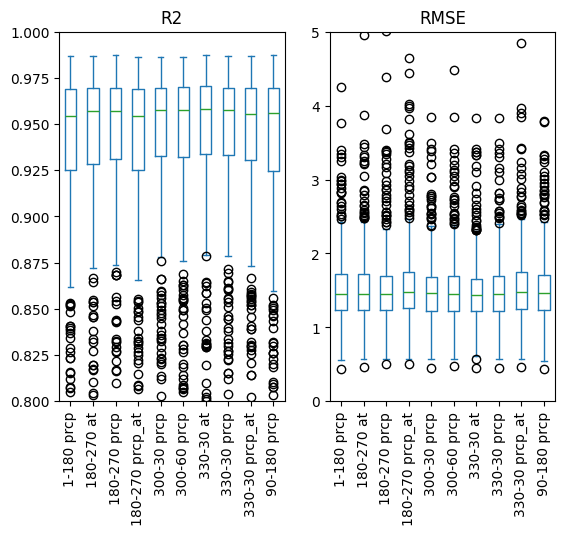

In [47]:
ax1, ax2 = best[["category", "RMSE", "R2"]].plot.box(by="category")
# Everything outside of these limits is outliers anyway
ax1.set_ylim(0.8, 1)
ax2.set_ylim(0, 5)
ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=90)